In [42]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, roc_curve, auc
import seaborn as sns

from utils import Pyutils as pyutils

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (15,10)

SOURCE_PATH = os.getcwd()
INPUTS_PATH = os.path.join(SOURCE_PATH, "data", "inputs")
OUTPUTS_PATH = os.path.join(SOURCE_PATH, "data", "outputs")
DATASET_NAMES = ["betadgp_covdgp_data", "betadgp_beta2x2_data", "betadgp_data"]
TARGET_NAME = "betas_dgp"
MODEL_TAGS = ["ffnn_class_1_100_swish_10_50", "ffnn_class_2_100_swish_10_50",
              "ffnn_class_3_100_swish_10_50", "ffnn_class_4_100_swish_10_50",
              "fnn_class_5_100_swish_10_50"]
ROC_THRESHOLD = 0

## 0) Sanity check

### Target and covariates

In [6]:
train_data = pd.read_csv(os.path.join(INPUTS_PATH, "ar1_150_random", "betadgp_covdgp_data.csv"))
train_data.set_index(["Var1", "Var2"], inplace=True)
y_train = train_data[[TARGET_NAME]].to_numpy()
X_train = train_data.drop([TARGET_NAME], axis=1).to_numpy()

In [7]:
pd.concat([pd.DataFrame(y_train, columns=["y"]), pd.DataFrame(X_train, columns=["X"])], axis=1).head()

,y,X
0,0.000000,-0.154283
1,0.000000,0.029536
2,0.212277,0.060256
3,0.000000,-0.047562
4,0.000000,0.017272


<AxesSubplot:xlabel='X', ylabel='y'>

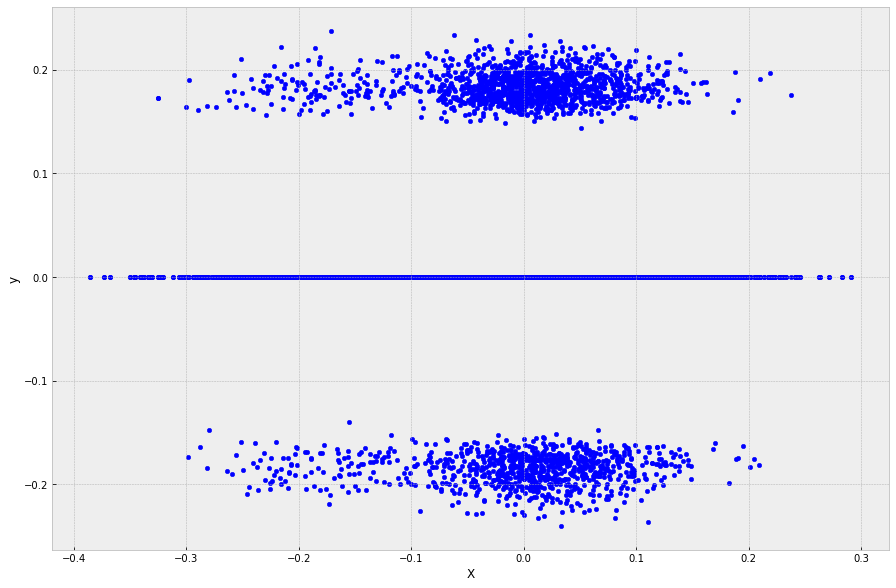

In [5]:
pd.concat([pd.DataFrame(y_train, columns=["y"]), pd.DataFrame(X_train, columns=["X"])], axis=1).plot.scatter(y="y", x="X")

### ROC curve

In [43]:
model_tag = MODEL_TAGS[0]
dgp_name = os.listdir(os.path.join(OUTPUTS_PATH, model_tag))[0]
ds = DATASET_NAMES[0]

print(model_tag, " -> ", dgp_name, " -> ", ds)

check1 = pd.read_csv(os.path.join(OUTPUTS_PATH, model_tag, dgp_name, ds + "_result.csv"))
check2 = pyutils.load_pkl(path=os.path.join(OUTPUTS_PATH, model_tag, dgp_name, ds + "_model.pickle"))

ffnn_class_1_100_swish_10_50  ->  ar1_150_random  ->  betadgp_covdgp_data


In [44]:
fpr, tpr, thresholds = roc_curve(y_true=check1["y"],
                                 y_score=check1["pred"],
                                 pos_label=2)
roc_auc = auc(fpr, tpr)

/Users/danieloliveira/opt/anaconda3/envs/dcuoliveira/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


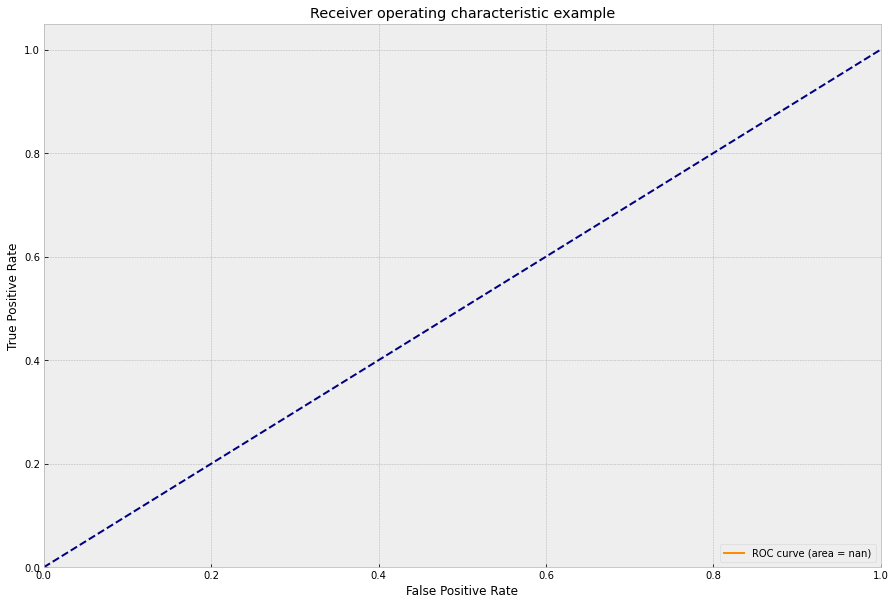

In [45]:
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")

## 1) Aggregate all results

In [5]:
mini_output_report = []
all_data = []
model_summary = []
class_data = []
cm_data = []
roc = []
idx = 0
for model_tag in tqdm(MODEL_TAGS,
                      desc="Append all model results"):
    
    DGPS = os.listdir(os.path.join(OUTPUTS_PATH, model_tag))
    for dgp_name in DGPS:
        for ds in DATASET_NAMES:
            
            
            try:
                check1 = pd.read_csv(os.path.join(OUTPUTS_PATH, model_tag, dgp_name, ds + "_result.csv"))
                check2 = pyutils.load_pkl(path=os.path.join(OUTPUTS_PATH, model_tag, dgp_name, ds + "_model.pickle"))
            except:
                print("We coudn't find the output for " + model_tag + " " + dgp_name)
                mini_output_report.append(pd.DataFrame([{"model": model_tag, "dgp": dgp_name, "dataset": ds}]))
                continue
            
            data = check1
            data["model"] = model_tag
            data["dgp"] = dgp_name
            data["dataset"] = ds
            
#             # confusion matrix            
#             tmp_confusion_matrix = pd.DataFrame(confusion_matrix(data['y'],
#                                                                  data['pred']))
#             tmp_confusion_matrix.index.name = "Actual"
#             tmp_confusion_matrix.columns.name = "Predicted"
                                          
#             tmp_confusion_matrix = (tmp_confusion_matrix / tmp_confusion_matrix.sum().sum()) * 100
#             melt_tmp_confusion_matrix = tmp_confusion_matrix.reset_index()
#             melt_tmp_confusion_matrix = melt_tmp_confusion_matrix.melt("Actual")
#             melt_tmp_confusion_matrix["model"] = model_tag
#             melt_tmp_confusion_matrix["dgp"] = dgp_name
#             melt_tmp_confusion_matrix["dataset"] = ds
#             melt_tmp_confusion_matrix["number_of_variables"] = int(dgp_name.split("_")[1])
            
#             cm_data.append(melt_tmp_confusion_matrix)
            
            tmp_roc = pyutils.roc_from_scratch(y_pred=data["pred"],
                                               y_true=np.where(data["y"] > 0, 1, 0),
                                               partitions=100)
            tmp_roc_df = pd.DataFrame(tmp_roc, columns=["TP", "FP"])
            tmp_roc_df["model"] = model_tag
            tmp_roc_df["dgp"] = dgp_name
            tmp_roc_df["dataset"] = ds
            tmp_roc_df["number_of_variables"] = int(dgp_name.split("_")[1])
            
            roc.append(tmp_roc_df)
            
#             idx += 1
            
            all_data.append(data)
            
all_data_df = pd.concat(all_data, axis=0)
# cm_data_df = pd.concat(cm_data, axis=0).reset_index(drop=True)
all_roc_df = pd.concat(roc, axis=0)

Append all model results:   0%|          | 0/4 [00:00<?, ?it/s]

We coudn't find the output for ffnn_class_1_100_swish_10_50 ar1_300_random


Append all model results:  25%|██▌       | 1/4 [00:01<00:03,  1.12s/it]

We coudn't find the output for ffnn_class_1_100_swish_10_50 ar1_250_random
We coudn't find the output for ffnn_class_2_100_swish_10_50 ar1_300_random
We coudn't find the output for ffnn_class_2_100_swish_10_50 ar1_300_random


Append all model results:  50%|█████     | 2/4 [00:02<00:02,  1.03s/it]

We coudn't find the output for ffnn_class_2_100_swish_10_50 ar1_250_random
We coudn't find the output for ffnn_class_3_100_swish_10_50 ar1_300_random
We coudn't find the output for ffnn_class_3_100_swish_10_50 ar1_300_random


Append all model results:  75%|███████▌  | 3/4 [00:02<00:00,  1.06it/s]

We coudn't find the output for ffnn_class_3_100_swish_10_50 ar1_250_random
We coudn't find the output for ffnn_class_3_100_swish_10_50 ar1_250_random


Append all model results: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

We coudn't find the output for ffnn_class_4_100_swish_10_50 ar1_200_random
We coudn't find the output for ffnn_class_4_100_swish_10_50 ar1_200_random


# 2) Compute relevant metrics

> a) Mean squared error

> b) Mean absolute error

> d) ROC curve

> e) Confusion matrices

In [13]:
metrics_df = all_data_df.drop(["Var1", "Var2"], axis=1)
mse_group_df = metrics_df.groupby(["model", "dgp", "dataset"]).apply(pyutils.mse_melt).reset_index()
mae_group_df = metrics_df.groupby(["model", "dgp", "dataset"]).apply(pyutils.mae_melt).reset_index()

### a) MSE histogram

In [14]:
hist_mse = []
for model in mse_group_df["model"].unique():
    tmp_hist_mse = mse_group_df.loc[mse_group_df["model"] == model][["mse"]]
    tmp_hist_mse.rename(columns={"mse": model}, inplace=True)
    
    hist_mse.append(tmp_hist_mse.reset_index(drop=True))
hist_mse_df = pd.concat(hist_mse, axis=1)

Text(0.5, 1.0, 'MSE of the OOS forecast for each test simulation')

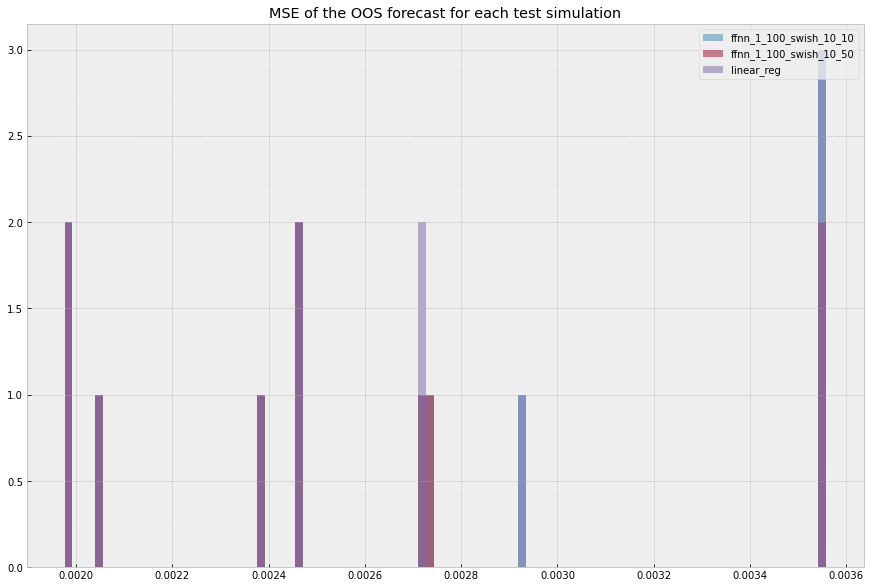

In [15]:
bins = np.linspace(hist_mse_df.min().min(), hist_mse_df.max().max(), 100)
for colname in hist_mse_df.columns:
    plt.hist(hist_mse_df[colname], bins, alpha=0.5, label=colname)
plt.legend(loc='upper right')
plt.title("MSE of the OOS forecast for each test simulation")

No handles with labels found to put in legend.


(array([0, 1, 2]),
 [Text(0, 0, 'ffnn_1_100_swish_10_10'),
  Text(1, 0, 'ffnn_1_100_swish_10_50'),
  Text(2, 0, 'linear_reg')])

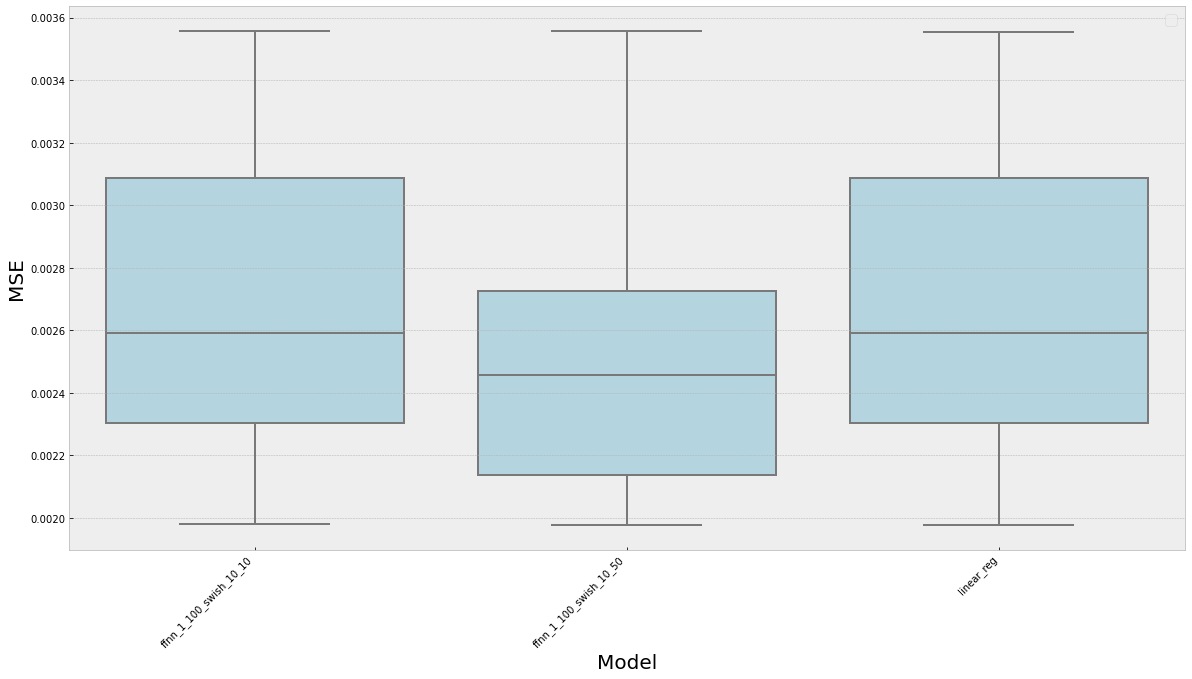

In [16]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x="variable", y="value", data=hist_mse_df.melt(), ax=ax, color='lightblue')
ax.set_ylabel("MSE", fontsize=20)
ax.set_xlabel("Model", fontsize=20)
ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.legend(loc="best", fontsize=15)
plt.xticks(rotation=45, ha="right")

### b) MAE histogram

In [22]:
hist_mae = []
for model in mae_group_df["model"].unique():
    tmp_hist_mae = mae_group_df.loc[mae_group_df["model"] == model][["mae"]]
    tmp_hist_mae.rename(columns={"mae": model}, inplace=True)
    
    hist_mae.append(tmp_hist_mae.reset_index(drop=True))
hist_mae_df = pd.concat(hist_mae, axis=1)

Text(0.5, 1.0, 'MAE of the OOS forecast for each test simulation')

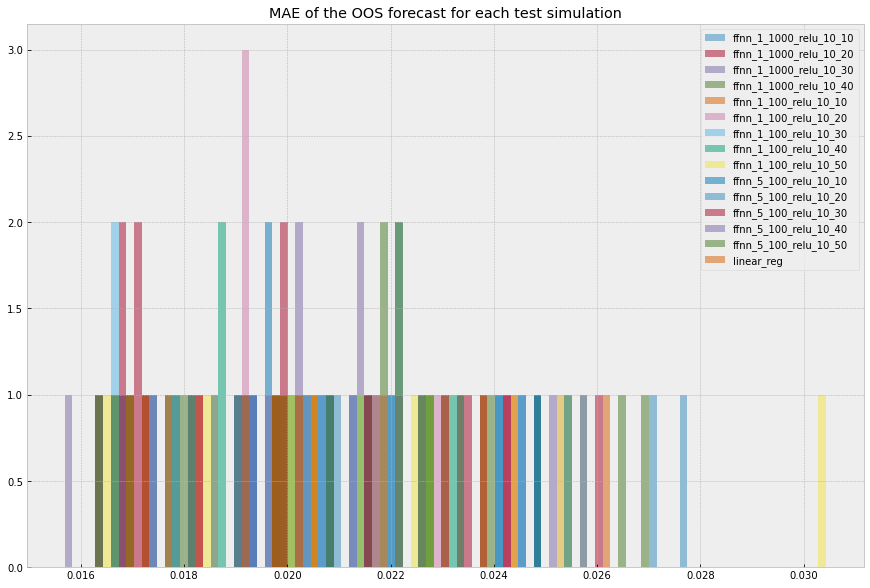

In [23]:
bins = np.linspace(hist_mae_df.min().min(), hist_mae_df.max().max(), 100)
for colname in hist_mae_df.columns:
    plt.hist(hist_mae_df[colname], bins, alpha=0.5, label=colname)
plt.legend(loc='upper right')
plt.title("MAE of the OOS forecast for each test simulation")

No handles with labels found to put in legend.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'ffnn_1_1000_relu_10_10'),
  Text(1, 0, 'ffnn_1_1000_relu_10_20'),
  Text(2, 0, 'ffnn_1_1000_relu_10_30'),
  Text(3, 0, 'ffnn_1_1000_relu_10_40'),
  Text(4, 0, 'ffnn_1_100_relu_10_10'),
  Text(5, 0, 'ffnn_1_100_relu_10_20'),
  Text(6, 0, 'ffnn_1_100_relu_10_30'),
  Text(7, 0, 'ffnn_1_100_relu_10_40'),
  Text(8, 0, 'ffnn_1_100_relu_10_50'),
  Text(9, 0, 'ffnn_5_100_relu_10_10'),
  Text(10, 0, 'ffnn_5_100_relu_10_20'),
  Text(11, 0, 'ffnn_5_100_relu_10_30'),
  Text(12, 0, 'ffnn_5_100_relu_10_40'),
  Text(13, 0, 'ffnn_5_100_relu_10_50'),
  Text(14, 0, 'linear_reg')])

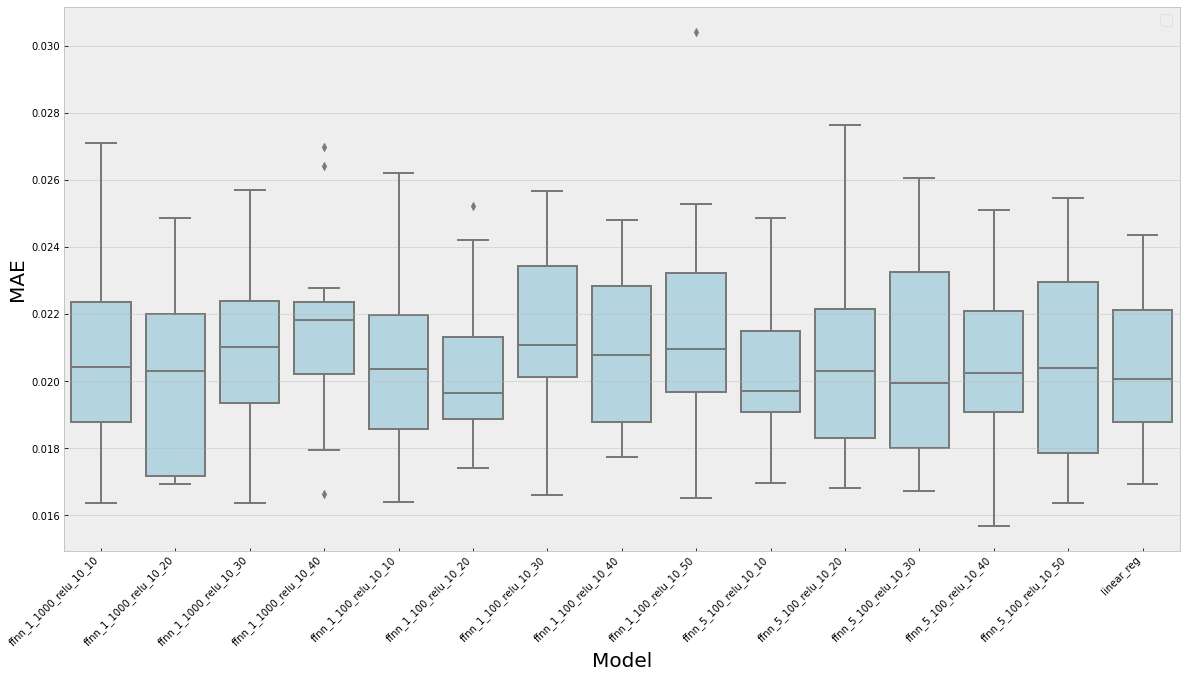

In [25]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x="variable", y="value", data=hist_mae_df.melt(), ax=ax, color='lightblue')
ax.set_ylabel("MAE", fontsize=20)
ax.set_xlabel("Model", fontsize=20)
ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.legend(loc="best",fontsize=15)
plt.xticks(rotation=45, ha="right")

### c) ROC Curve

#### SANITY

/Users/danieloliveira/opt/anaconda3/envs/dcuoliveira/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


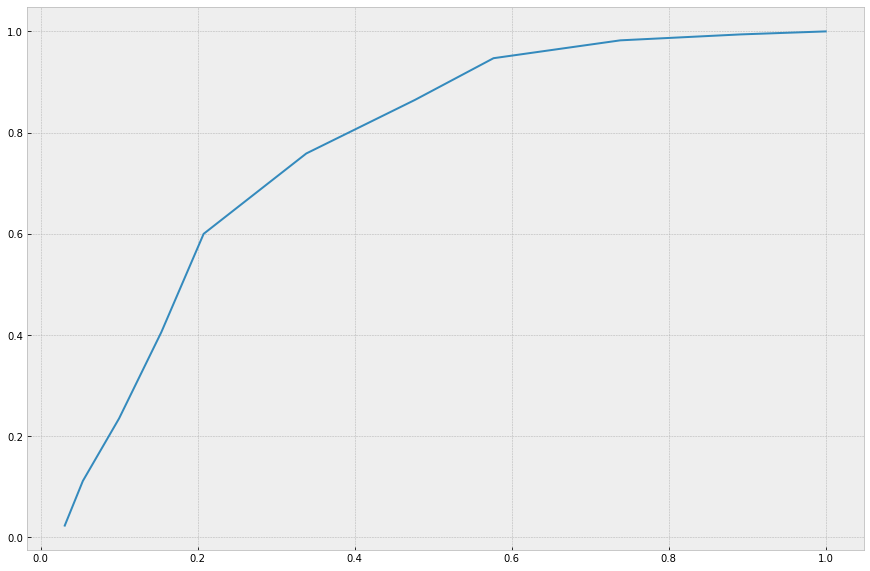

In [29]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=1000, n_informative=10, n_features=20, flip_y=0.2)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = RandomForestClassifier()
model.fit(X_train, y_train)

prob_vector = model.predict_proba(X_test)[:, 1]

sanity_roc = pyutils.roc_from_scratch(y_pred=pd.DataFrame(prob_vector),
                                      y_true=pd.DataFrame(y_test),
                                      partitions=100)
sanity_roc_df = pd.DataFrame(sanity_roc, columns=["fpr", "tpr"])

plt.plot(sanity_roc_df["tpr"],
         sanity_roc_df["fpr"])

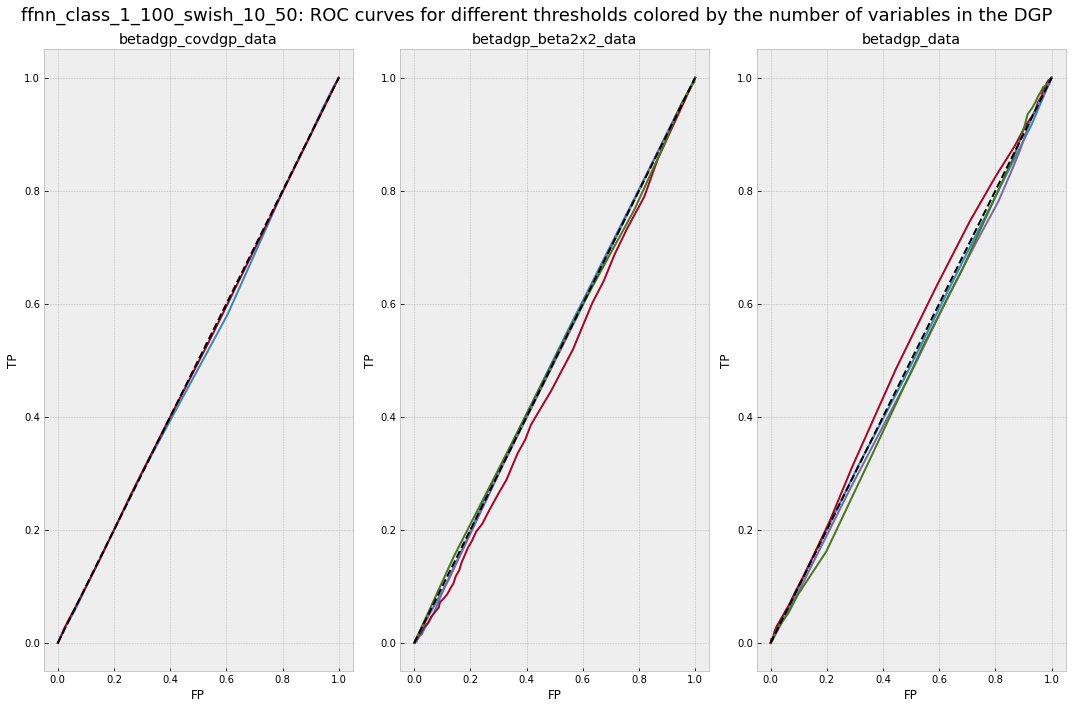

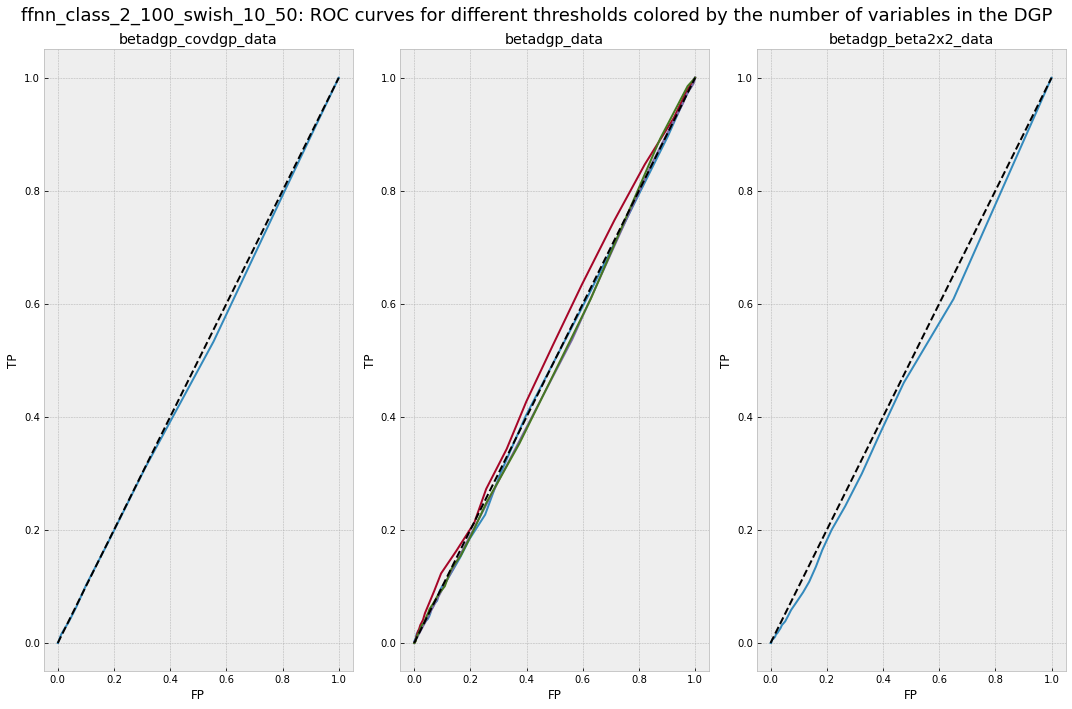

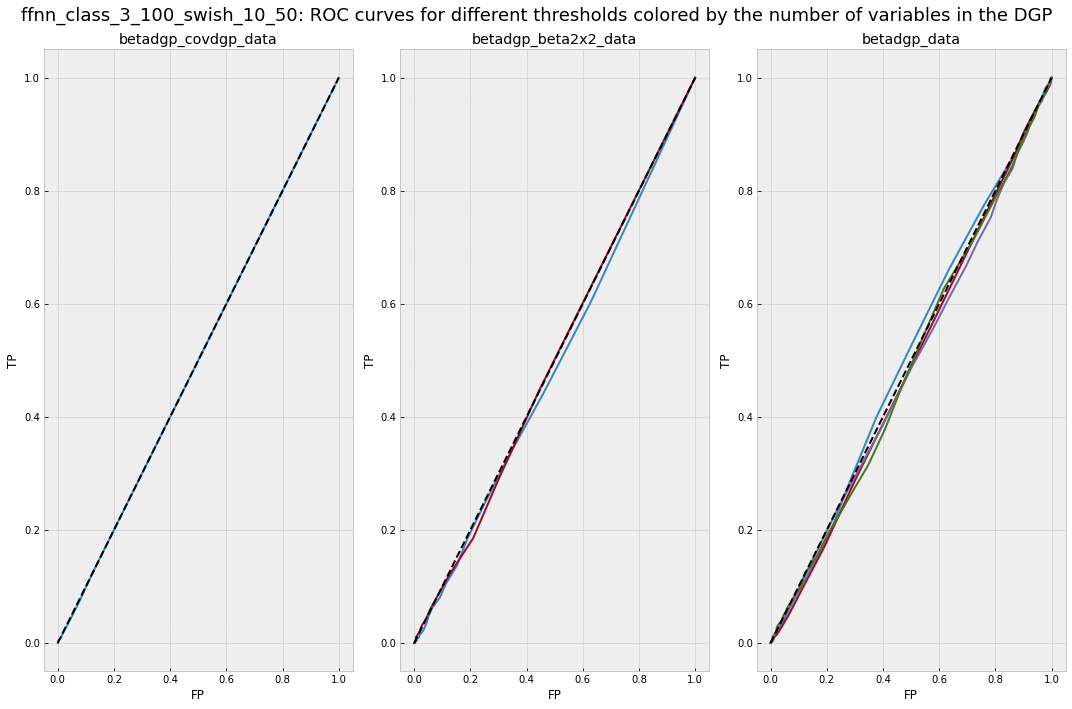

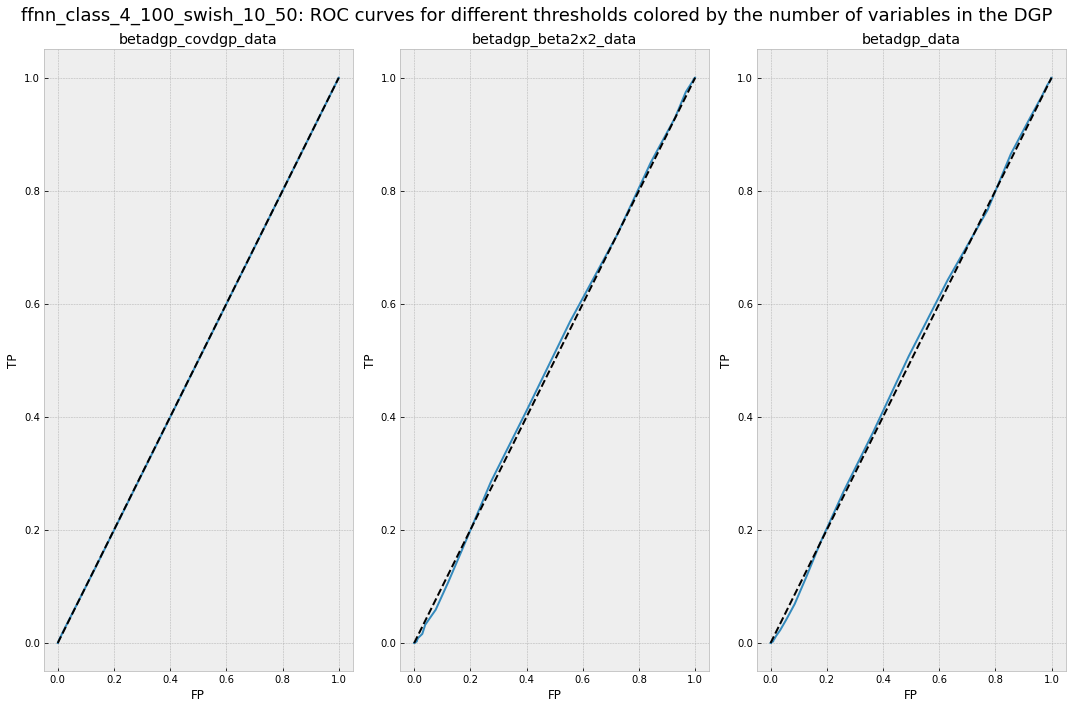

In [32]:
for i, tag in enumerate(MODEL_TAGS):
    tmp_model_df = all_roc_df.loc[all_roc_df["model"] == tag]
    
    fig, ax = plt.subplots(nrows=1, ncols=len(tmp_model_df["dataset"].unique()))
    for j, ds in enumerate(tmp_model_df["dataset"].unique()):
        groups = tmp_model_df.loc[tmp_model_df["dataset"] == ds].groupby(["number_of_variables"])

        for name, group in groups:
            ax[j].plot(group["FP"],
                       group["TP"],
                       ms=5,
                       label=name)
        ax[j].set_ylabel("TP")
        ax[j].set_xlabel("FP")
        ax[j].plot([0, 1], [0, 1], "--", color = 'black', linewidth = 2)
        ax[j].set_title(ds)
    
    fig.suptitle(tag + ": ROC curves for different thresholds colored by the number of variables in the DGP", fontsize=18)
    fig.tight_layout()